In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import math 

In [12]:
data = pd.read_csv('all_stocks_5yr.csv')

In [13]:
data

,date,open,high,low,close,volume,Name
0,2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
1,2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2,2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
3,2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
4,2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL
...,...,...,...,...,...,...,...
619035,2018-02-01,76.84,78.27,76.69,77.82,2982259,ZTS
619036,2018-02-02,77.53,78.12,76.73,76.78,2595187,ZTS
619037,2018-02-05,76.64,76.92,73.18,73.83,2962031,ZTS
619038,2018-02-06,72.74,74.56,72.13,73.27,4924323,ZTS


In [14]:
stocks = set(data['Name'])

stock_dict = {}
for stock in stocks:
    stock_dict[stock] = []

In [15]:
for i, row in data.iterrows():
    if '2018' in row['date']:
        stock_dict[row['Name']].append(dict(row))

In [16]:
# now build the correlation network 

In [17]:
def mean(stock_i):
    mean = 0
    for item in stock_dict[stock_i]:
        mean += item['close']
    return mean/len(stock_dict[stock_i])
        

In [18]:
def cross_correlation(stock_i, stock_j):
    cross_c = 0
    numerator = 0
    denom_i = 0 
    denom_j = 0
    mean_i = mean(stock_i)
    mean_j = mean(stock_j)
    
    for item_i in stock_dict[stock_i]:
        if '2018' in item_i['date']: 
            for item_j in stock_dict[stock_j]:
                if item_i['date'] == item_j['date']:
                    numerator += (item_i['close'] - mean_i) * (item_j['close'] - mean_j)
                    denom_i += (item_i['close'] - mean_i)**2
                    denom_j += (item_j['close'] - mean_j)**2
                
    
    return numerator/(math.sqrt(denom_i) * math.sqrt(denom_j))
                

In [19]:
def create_correlation_matrix():
    lst = []
    for i in stock_dict.keys():
        sub_lst = []
        for j in stock_dict.keys():
            sub_lst.append(cross_correlation(i, j))
        lst.append(sub_lst)
    return lst 

In [20]:
correlation_matrix = create_correlation_matrix()

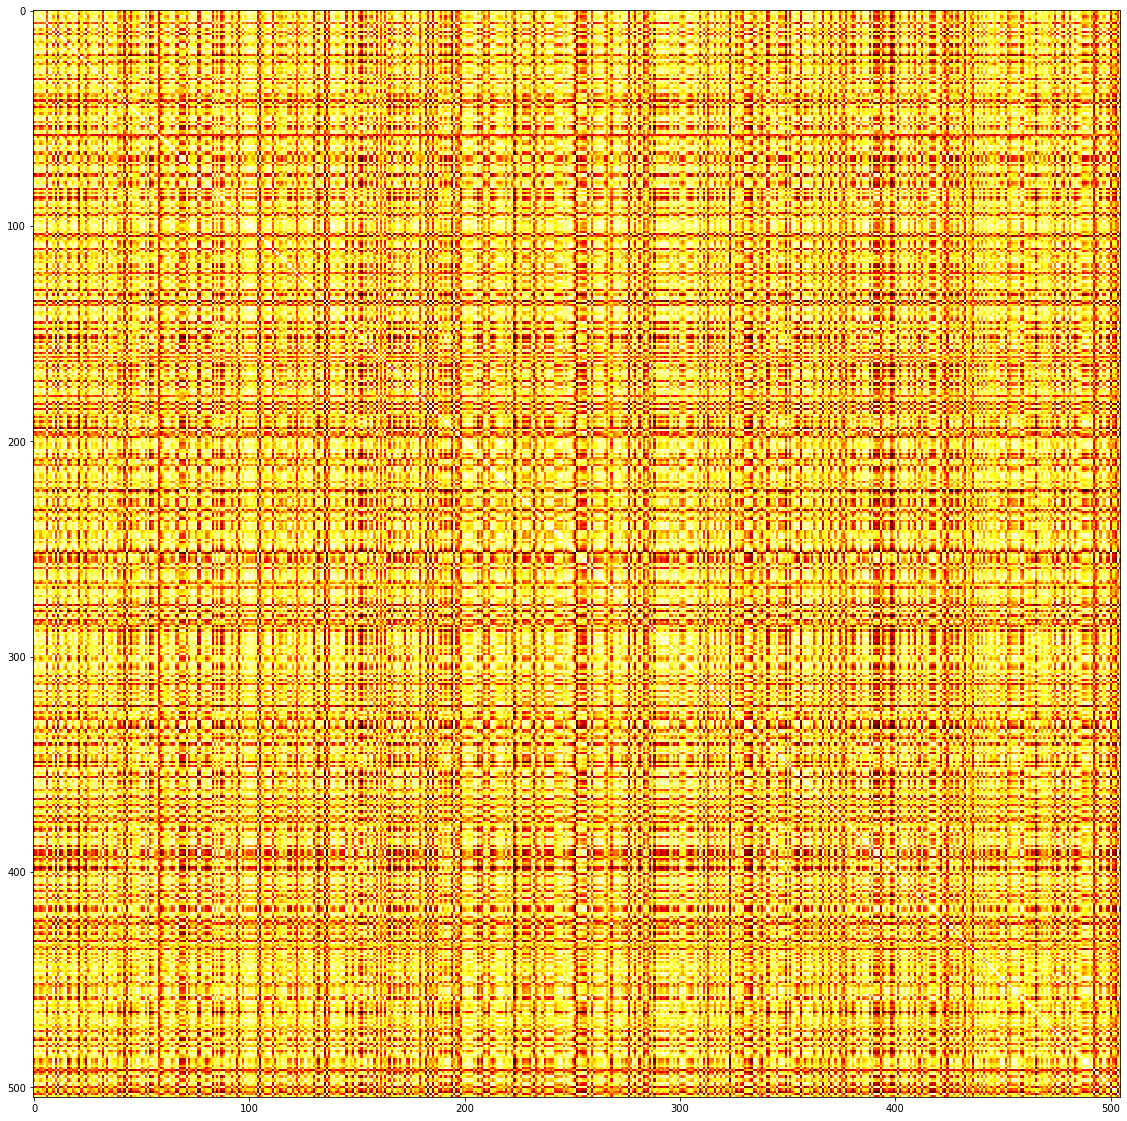

In [21]:
plt.figure(figsize=(20, 20))
plt.imshow(correlation_matrix, cmap='hot', interpolation='nearest')
plt.show()

In [22]:
np.mean(correlation_matrix)

0.3824780648891503

In [23]:
theta = .9
def adj_matrix(correlation_matrix):
    lst = []
    for row_index in range(len(correlation_matrix)):
        sub_lst = []
        for col_index in range(len(correlation_matrix[row_index])):
            if row_index != col_index and abs(correlation_matrix[row_index][col_index]) > theta:
                sub_lst.append(1)
            else:
                sub_lst.append(0)
        lst.append(sub_lst)
    return lst

In [24]:
def create_correlation_network():
    g = nx.Graph()
    for key in stock_dict.keys():
        g.add_node(key)
        
    adj_list = adj_matrix(create_correlation_matrix())
    dict_keys = list(stock_dict.keys())
    
    for row_index in range(len(adj_list)):
        for col_index in range(len(adj_list[row_index])):
            if adj_list[row_index][col_index]:
                g.add_edge(dict_keys[row_index], dict_keys[col_index])
    return g
    

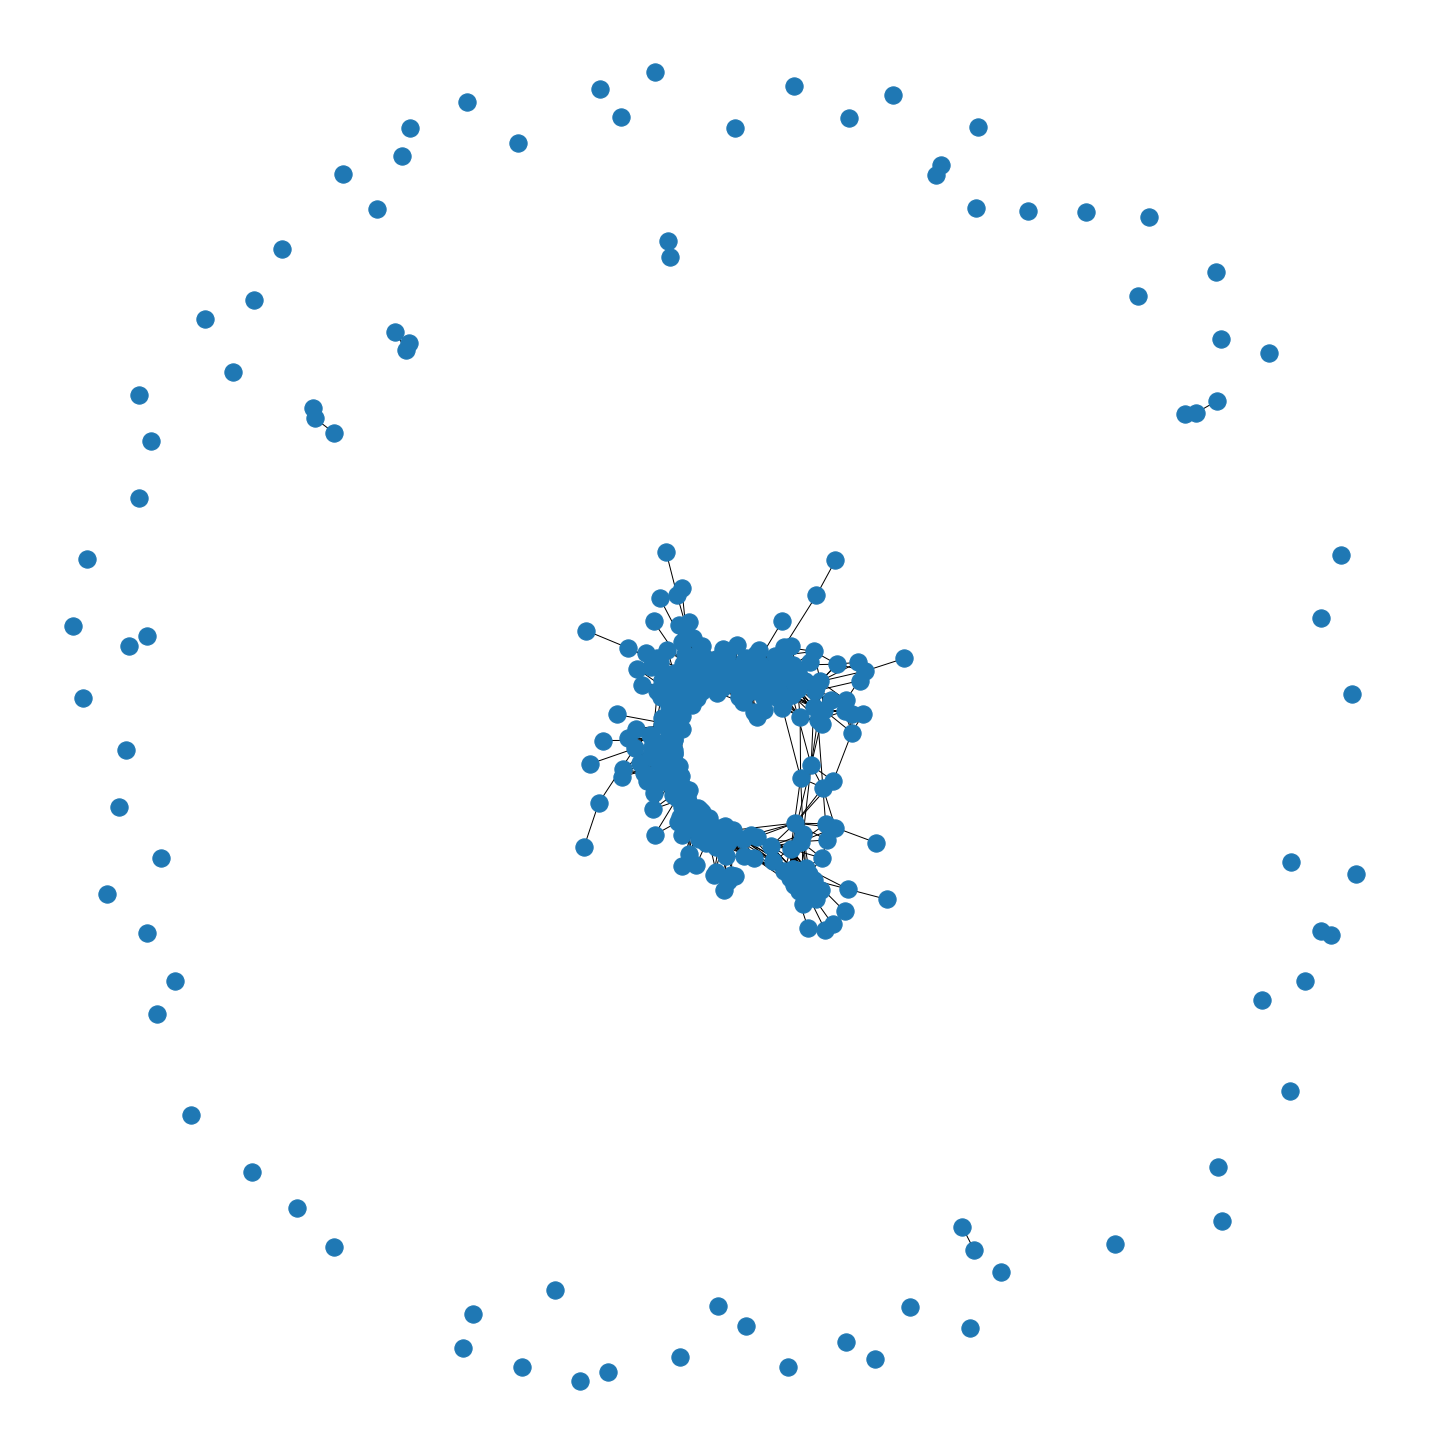

In [25]:
g = create_correlation_network()

plt.figure(figsize=(20, 20))
nx.draw_spring(g)

#### NOW FIND THE CENTRALITY MEASURES

The general ideas is to select the stocks with high centralities, which measure different importances of the stock 
relative to the market.

IN THE FUTURE USE MEASURES TO MAKE A HEDGE, THI strategy is fine for now since our data is from a time period 
of rapid market growth, so the choosing stocks that are highly correlated with the market is fine. In the future, 
we need to create a portfolio that hedges this risk AND expand our time period to the 2020s. 


In [65]:
def solve_optimization_problem():
    return 1/3  

In [66]:
# Find the average centralities of all stocks
def find_average_centralities(graph):
    average_centrailites = dict()
    scale_factor = solve_optimization_problem()
    
    degree_centrality = nx.degree_centrality(graph)
    closeness_centrality = nx.closeness_centrality(graph)
    betweenness_centrality = nx.betweenness_centrality(graph)
    
    for node in graph.nodes():
        average_centrailites[node] = scale_factor * (degree_centrality[node] + closeness_centrality[node] + betweenness_centrality[node])
        
        
    return average_centrailites

In [74]:
def get_top_stocks(top_percent, graph):
    c_avgs = find_average_centralities(graph)
    sorted_c_avgs = sorted(c_avgs, key=c_avgs.get, reverse=True)
    num_stocks = math.floor(top_percent * len(c_avgs.keys()))
    return sorted_c_avgs[:num_stocks]

def get_bottom_stocks(bottom_percent, graph):
    c_avgs = find_average_centralities(graph)
    sorted_c_avgs = sorted(c_avgs, key=c_avgs.get, reverse=False)
    num_stocks = math.floor(bottom_percent * len(c_avgs.keys()))
    return sorted_c_avgs[:num_stocks]


In [76]:
print(get_top_stocks(.10, g))
print(get_bottom_stocks(0.10, g))

['AOS', 'PKI', 'A', 'ZTS', 'PRU', 'HLT', 'MTD', 'ABC', 'ORCL', 'C', 'FLIR', 'BRK.B', 'MS', 'CSCO', 'HD', 'HUM', 'GOOG', 'DG', 'FLR', 'HPQ', 'V', 'BAC', 'KIM', 'GPC', 'L', 'GOOGL', 'ALLE', 'BDX', 'STI', 'EXPD', 'PCAR', 'HES', 'ITW', 'AAP', 'MAR', 'GT', 'SYY', 'JPM', 'COTY', 'GPN', 'HP', 'IVZ', 'MCK', 'HON', 'WAT', 'CTSH', 'HBAN', 'STT', 'RJF', 'FISV']
['CBOE', 'XL', 'PPG', 'K', 'EXC', 'SWKS', 'TPR', 'FE', 'AES', 'MMC', 'JCI', 'CBS', 'EXPE', 'JWN', 'ES', 'MAT', 'CTL', 'EQIX', 'SYF', 'T', 'HBI', 'DRE', 'APTV', 'CNP', 'MCHP', 'SLG', 'CME', 'MKC', 'STZ', 'EVHC', 'HRB', 'NAVI', 'NEE', 'INTC', 'EA', 'BLL', 'LB', 'BMY', 'GS', 'ALXN', 'HAS', 'QRVO', 'AKAM', 'ZBH', 'XLNX', 'MU', 'PEG', 'RHI', 'MOS', 'EL']


In [69]:
ffm = pd.read_csv('F-F_Research_Data_Factors_daily.CSV') 

In [71]:
## parse through 

,Date,Mkt-RF,SMB,HML,RF
0,19260701,0.10,-0.25,-0.27,0.009
1,19260702,0.45,-0.33,-0.06,0.009
2,19260706,0.17,0.30,-0.39,0.009
3,19260707,0.09,-0.58,0.02,0.009
4,19260708,0.21,-0.38,0.19,0.009
...,...,...,...,...,...
25434,20230223,0.46,0.21,-0.23,0.018
25435,20230224,-1.09,-0.49,1.26,0.018
25436,20230227,0.31,0.15,-0.29,0.018
25437,20230228,-0.26,0.62,-0.71,0.018
